### Adapting GVP for arbitrary (proteins) point clouds

In [2]:
import os
import sys
import time
sys.path.append("../geometric_vector_perceptron")

import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom utils
from data_handler import *
from data_utils import *
# custom model
from geometric_vector_perceptron import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [3]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

### Dataloader for training

In [5]:
MAX_LEN = 120
MAX_PROTS = 800

In [ ]:
/Users/ericalcaidealdeano/Desktop/projects/faster_nerf/mp_nerf/sidechainnet_data

In [7]:
# !mkdir sidechainnet_data
!cp /Users/ericalcaidealdeano/Desktop/projects/faster_nerf/mp_nerf/sidechainnet_data/sidechainnet_casp7_30.pkl sidechainnet_data/sidechainnet_casp7_30.pkl

In [8]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(3))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


## Data encoding dims and instantiate model

In [6]:
NEEDED_INFO = {"cutoffs": ["25_closest"],
               "bond_scales": [1],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5] # will encode 3 vectors with this
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)

# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
embedd_info

{'point_n_vectors': 7,
 'point_n_scalars': 48,
 'bond_n_vectors': 1,
 'bond_n_scalars': 4,
 'bond_embedding_nums': [2]}

In [8]:
# define model
model = GVP_Network(n_layers=4, feats_x_in=48, vectors_x_in=7,
                                feats_x_out=48, vectors_x_out=7,
                                feats_edge_in=4, vectors_edge_in=1,
                                feats_edge_out=4, vectors_edge_out=1,
                                embedding_nums=[36, 20], embedding_dims=[16,16], # from _nums to _dims
                                edge_embedding_nums=[2], edge_embedding_dims=[2], residual=True)

### Train

In [10]:
model = model.to(device) # .double()

In [26]:
noise = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 2*n_per_iter ): # 1*n_per_iter
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del true_coords, angles, pre_target_x, edge_index, edge_attrs
        del scores, target_coords, pred_coords, base_coords
        del encoded, pre_target, target_aligned, pred_aligned
        gc.collect()
        
    # get input data and target - copy to gpu
    seq, true_coords, angles, padding_seq, mask = get_prot(dataloader_=dataloaders_,
                                                           vocab_=VOCAB, 
                                                           max_len=MAX_LEN, 
                                                           verbose=0)
    # define edge_attr recalculator + add seq for feature calc
    NEEDED_INFO["seq"] = seq[:-padding_seq]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
    recalc_edge = partial(encode_whole_bonds, x_format = "encode",
                                              embedd_info = embedd_info,
                                              needed_info = NEEDED_INFO,
                                              free_mem = True)
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()
    # target is the position of every atom (unit_vec, norm_scale)
    pre_target = encode_whole_protein(seq,
                                      true_coords,
                                      angles,
                                      padding_seq,
                                      needed_info=NEEDED_INFO, free_mem=True)
    pre_target_x, _, _, embedd_info = pre_target
    # encode as needed (noise mask)
    encoded = encode_whole_protein( seq,
                                    true_coords + noise*torch.randn_like(true_coords),
                                    angles,
                                    padding_seq,
                                    needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # add position coords
    cloud_mask = scn_cloud_mask(seq[:-padding_seq])
    # cloud is all points, chain is all for which we have labels
    chain_mask = (mask[:-padding_seq].unsqueeze(-1) * cloud_mask)
    flat_chain_mask = rearrange(chain_mask.bool(), 'l c -> (l c)')
    cloud_mask = cloud_mask.bool()
    flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
    
    # predict
    scores = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                           recalc_edge=recalc_edge, verbose = False)
    # format pred and target
    target = from_encode_to_pred(pre_target_x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    pred   = from_encode_to_pred(scores, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    base   = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    # MEASURE ERROR
    
    # option 1: loss is MSE on output tokens
    # loss_ = (target-pred)**2
    # loss  = loss_.mean()
    
    # option 2: loss is RMSD on reconstructed coords - unit vector + norm
    target_coords = target[:, 3:4] * target[:, :3] #  * (1 / torch.norm(target[:, :3], dim=-1, keepdim=True) )
    pred_coords   = pred[:, 3:4] * pred[:, :3] # * ( 1 / torch.norm(pred[:, :3], dim=-1, keepdim=True) )
    base_coords   = base[:, 3:4] * base[:, :3] # * ( 1 / torch.norm(base[:, :3], dim=-1, keepdim=True) )
    ## # measure error : align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
        base_aligned, _ = kabsch_torch(base_coords.t(), target_coords.t())
        loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5 
        loss_base = ( (base_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        loss = ( (pred_coords.t() - target_coords.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5
        loss_base = ( (base_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()**0.5 
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 10 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
    if iteration % n_per_iter == (n_per_iter-1):
        print("---------------------------------")

BATCH: 1 / 800, loss: 11.679840087890625, baseline_loss: 0.5028480291366577, time: 2.5049657821655273
BATCH: 11 / 800, loss: 13.957351684570312, baseline_loss: 0.49240642786026, time: 21.85397505760193
BATCH: 21 / 800, loss: 15.263800621032715, baseline_loss: 0.513088583946228, time: 21.473390817642212
BATCH: 31 / 800, loss: 15.945378303527832, baseline_loss: 0.49637481570243835, time: 19.198776245117188
BATCH: 41 / 800, loss: 7.6643290519714355, baseline_loss: 0.4943629801273346, time: 21.638707160949707
BATCH: 51 / 800, loss: 5.566545009613037, baseline_loss: 0.5068678855895996, time: 20.894384145736694
BATCH: 61 / 800, loss: 6.71418571472168, baseline_loss: 0.5163059830665588, time: 22.30014395713806
BATCH: 71 / 800, loss: 7.025476455688477, baseline_loss: 0.5097765922546387, time: 23.88046407699585
BATCH: 81 / 800, loss: 14.073709487915039, baseline_loss: 0.5126726627349854, time: 24.329927921295166
BATCH: 91 / 800, loss: 10.015759468078613, baseline_loss: 0.5037643313407898, time:

---------------------------------
BATCH: 801 / 800, loss: 0.6584168672561646, baseline_loss: 0.505185604095459, time: 29.450342178344727
BATCH: 811 / 800, loss: 0.9494523406028748, baseline_loss: 0.504190981388092, time: 29.83066439628601
BATCH: 821 / 800, loss: 1.3835290670394897, baseline_loss: 0.4978073835372925, time: 33.83199191093445
BATCH: 831 / 800, loss: 0.737916111946106, baseline_loss: 0.501071572303772, time: 28.406415939331055
BATCH: 841 / 800, loss: 0.627335786819458, baseline_loss: 0.48738807439804077, time: 32.42369794845581
BATCH: 851 / 800, loss: 0.6225571632385254, baseline_loss: 0.5050600171089172, time: 30.753106832504272
BATCH: 861 / 800, loss: 0.5739322900772095, baseline_loss: 0.5050042271614075, time: 30.75004291534424
BATCH: 871 / 800, loss: 0.7070193290710449, baseline_loss: 0.4990116059780121, time: 31.11135220527649
BATCH: 881 / 800, loss: 0.9720185399055481, baseline_loss: 0.4955193102359772, time: 31.99307417869568
BATCH: 891 / 800, loss: 0.52861642837524

BATCH: 1591 / 800, loss: 0.47767898440361023, baseline_loss: 0.49434947967529297, time: 36.96552610397339
---------------------------------


In [27]:
# 1 more epoch

BATCH: 1601 / 800, loss: 0.49370014667510986, baseline_loss: 0.49952220916748047, time: 773.2968761920929
BATCH: 1611 / 800, loss: 0.46814846992492676, baseline_loss: 0.5016999244689941, time: 37.540560722351074
BATCH: 1621 / 800, loss: 0.5043773651123047, baseline_loss: 0.4920327961444855, time: 38.175100326538086
BATCH: 1631 / 800, loss: 0.5238704681396484, baseline_loss: 0.48958098888397217, time: 34.10224199295044
BATCH: 1641 / 800, loss: 0.4854637086391449, baseline_loss: 0.5078785419464111, time: 38.918704986572266
BATCH: 1651 / 800, loss: 0.4940917193889618, baseline_loss: 0.48542898893356323, time: 37.7647008895874
BATCH: 1661 / 800, loss: 0.4759070873260498, baseline_loss: 0.500916600227356, time: 36.46912503242493
BATCH: 1671 / 800, loss: 0.46141794323921204, baseline_loss: 0.4870634973049164, time: 36.650562047958374
BATCH: 1681 / 800, loss: 0.5323461890220642, baseline_loss: 0.49343010783195496, time: 36.44774889945984
BATCH: 1691 / 800, loss: 0.4490007758140564, baseline_l

BATCH: 2381 / 800, loss: 0.46119847893714905, baseline_loss: 0.4949955344200134, time: 27.715550184249878
BATCH: 2391 / 800, loss: 0.46186941862106323, baseline_loss: 0.4967632591724396, time: 29.693592071533203
---------------------------------


In [13]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

0.4993029033392668

### Training Plot

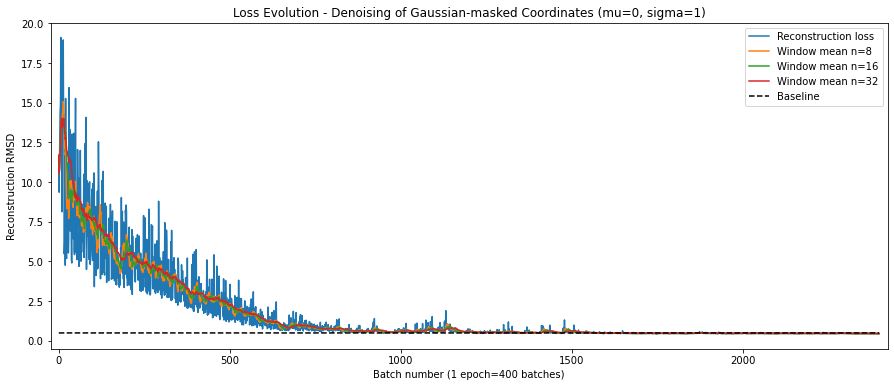

In [29]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

### Measure rmsd on (the last trained) reconstructed protein

* Not passing through the model

In [30]:
unfiltered = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
unfiltered_coords = unfiltered[:, :3] * unfiltered[:, 3:4]
print("MSE baseline coords: ", ((unfiltered_coords - target_coords)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(0.4974)


* passing through the model

In [31]:
# unfiltered = from_encode_to_pred(scores, embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
sample_pred_coords = pred[:, :3] * pred[:, 3:4]
# rotate / align
pred_aligned, target_aligned = kabsch_torch(sample_pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned - target_aligned)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(0.4541, grad_fn=<PowBackward0>)


In [32]:
# comparing errors in vector norm and unit vectors

In [33]:
(unfiltered[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
(pred[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
torch.norm(unfiltered[:, :3] - target[:, :3], dim=-1).view(-1).mean(), \
torch.norm(pred[:, :3] - target[:, :3], dim=-1).view(-1).mean()

(tensor(-0.0174),
 tensor(0.0943, grad_fn=<MeanBackward0>),
 tensor(0.0250),
 tensor(0.0257, grad_fn=<MeanBackward0>))

### Make a plot of a reconstructed protein

In [41]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = true_coords[:-14*padding_seq][scaffs["cloud_mask"].cpu().view(-1)]
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = base_aligned.t().cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_aligned.t().cpu()

In [42]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pre_target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_target.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [43]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_input.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [44]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pred_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_pred.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol